# Protein BERT 


In [1]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.25.1 which is incompatible.


In [2]:
!nvidia-smi

Mon Jan  2 20:14:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
VER = 0

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = f'Debug_{VER}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
import multiprocessing

multiprocessing.cpu_count()

2

# CFG

In [6]:
#### ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=True
    print_freq=100
    num_workers=2
    
    #model="Rostlab/prot_bert"
    model="facebook/esm2_t33_650M_UR50D" 
    gradient_checkpointing=False
    scheduler='constant' # ['linear', 'cosine', 'constant']
    batch_scheduler=True
    num_warmup_steps=0
    
    # LEARNING RATE. 
    # Suggested: Prot_bert = 5e-6, ESM2 = 5e-5
    epochs=1
    num_cycles=1.0
    encoder_lr=5e-5
    decoder_lr=5e-5
    batch_size=4
    
    # MODEL INFO - PROT_BERT
    total_layers = 30 
    initial_layers = 5 
    layers_per_block = 16 
    # MODEL INFO - FACEBOOK ESM2
    if 'esm2' in model:
        total_layers = int(model.split('_')[1][1:])
        initial_layers = 2 
        layers_per_block = 15 
        
    # FREEZE
    # Suggested: Prot_bert -8, ESM2 -1
    num_freeze_layers = total_layers - 1
    # NO FREEZE
    #num_freeze_layers = 0
    
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['target']
    seed=42
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    pca_dim = 128
    
if CFG.debug:
    CFG.epochs = 1
    CFG.trn_fold = [0]

# Library

In [7]:

# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import get_constant_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizers.__version__: 0.12.1
transformers.__version__: 4.25.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
def create_mutant(row) : 
    string = row.sequence
    position = row.seq_position
    new_character = str(row.mutant)
    temp = list(string)
    temp[position] = new_character
    string = "".join(temp)
    
    return string

In [10]:
thermo_data = pd.read_csv('/kaggle/input/thermotrain/thermo_train-2.csv')
thermo_data['mutant_seq'] = thermo_data.apply(lambda row : create_mutant(row),axis=1)
thermo_data = thermo_data.rename(columns={"seq_position":"position","PDB_chain":"PDB",'mutant':'mutation','dT':'dTm'})
thermo_data['CIF'] = np.nan

In [11]:
train = pd.read_csv('/kaggle/input/thermotrain/all_train_data_v17.csv')
train = train.loc[train.source.str.contains('jin')]
print('Train has shape:', train.shape )
train.head()

Train has shape: (5072, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN


In [12]:
train = pd.concat([train, thermo_data[train.columns]]).reset_index(drop=True)

In [13]:
train.shape

(12705, 10)

In [14]:
def add_spaces(x):
    return " ".join(list(x))
train.sequence = train.sequence.map(add_spaces)
train.mutant_seq = train.mutant_seq.map(add_spaces)
print('Train has shape',train.shape)
train.head()

Train has shape (12705, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D D L A T A A A R G ...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN


In [15]:
REMOVE_CT = 20
train['n'] = train.groupby('PDB').PDB.transform('count')
train = train.loc[train.n>REMOVE_CT]
print(f'After removing mutation groups with less than {REMOVE_CT} mutations, our data has shape:')
print( train.shape )

After removing mutation groups with less than 20 mutations, our data has shape:
(10116, 11)


In [16]:
# RANK NORMALIZE EACH GROUP OF MUTATION PROTEINS
from scipy.stats import rankdata
train['target'] = 0.5
for p in train.PDB.unique():
    target = 'dTm'
    tmp = train.loc[train.PDB==p,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.PDB==p,'target'] =\
        rankdata( train.loc[train.PDB==p,target] )/len( train.loc[train.PDB==p,target] )
train = train.reset_index(drop=True)

In [17]:
print('Our train data has',train.PDB.nunique(),'unique mutation groups')

Our train data has 144 unique mutation groups


In [18]:
train.target.describe()

count    10116.000000
mean         0.507117
std          0.288414
min          0.002070
25%          0.257732
50%          0.509579
75%          0.758621
max          1.000000
Name: target, dtype: float64

# CV split

In [19]:
from sklearn.model_selection import GroupKFold

In [20]:
# ====================================================
# CV split
# ====================================================
Fold = GroupKFold(n_splits=CFG.n_fold) 
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols], train.PDB)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    2024
1    2023
2    2023
3    2023
4    2023
dtype: int64

# Tokenizer

In [21]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

# Dataset

In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.labels = df[cfg.target_cols].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs1, inputs2, position, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model
The model architecture takes both wild type sequence and mutation sequence and location of mutation as input. Then it subtracts their embeddings and concatenates that with their individual embeddings. It does this with both single mutation token position and mean pooling of entire sequence. Finally a dense layer makes the regression prediction. See the model architecture below.

In [23]:
CFG.dropout_rate=0.06297340526648805
CFG.dense_layer_size=74
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

    
class AttentionPooling(nn.Module):
    def __init__(self, in_dim=1280):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        else:
            self.config = torch.load(config_path)
            #self.config = AutoConfig.from_pretrained(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = AttentionPooling()#MeanPooling()
        self.fc1 = nn.Linear(self.config.hidden_size, self.cfg.pca_dim)
        #self.fc2 = nn.Linear(self.cfg.pca_dim*6, 1)
        self._init_weights(self.fc1)
        #self._init_weights(self.fc2)
        self.activation = nn.ReLU()
        self.dropout1=nn.Dropout(p=CFG.dropout_rate)
        self.fc2=nn.Linear(in_features=self.cfg.pca_dim*6, out_features=CFG.dense_layer_size)
        self.fc3=nn.Linear(in_features=CFG.dense_layer_size, out_features=1)
        self._init_weights(self.fc2)
        self._init_weights(self.fc3)
        
      
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs, position):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, position)
        return feature

    def forward(self, inputs1, inputs2, position):
        feature1 = self.feature(inputs1, position)
        feature2 = self.feature(inputs2, position)
        
        feature1_2=self.fc1(feature2 - feature1)
        
        feature1=self.fc1(feature1)
        feature2=self.fc1(feature2)
        
        feature3 = self.feature(inputs1, inputs1['attention_mask'])
        feature4 = self.feature(inputs2, inputs2['attention_mask'])
        
        feature3_4=self.fc1(feature4 - feature3)
        
        feature3=self.fc1(feature3)
        feature4=self.fc1(feature4)
        
        feature = torch.cat((feature1, feature2, feature1_2,
                             feature3, feature4, feature3_4),axis=-1)

        output = self.dropout1(feature)
        output=self.fc2(output)
        output=self.activation(output)
        output=self.dropout1(output)
        output=self.fc3(output)
        return output

# Loss

In [24]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, _ = MCRMSE(y_trues, y_preds)
    return mcrmse_score

from scipy.stats import spearmanr
    
    
# def get_score(y_trues, y_preds):
#     score = np.abs( spearmanr( y_trues, y_preds ).correlation )
#     return score

# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs1, inputs2, position, labels) in enumerate(train_loader):
        #inputs1 = collate(inputs1)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        #inputs2 = collate(inputs2)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs1, inputs2, position, labels) in enumerate(valid_loader):
        #inputs = collate(inputs)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [26]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    print('### train shape:',train_folds.shape)
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    # FREEZE LAYERS
    if CFG.num_freeze_layers>0:
        print(f'### Freezing first {CFG.num_freeze_layers} layers.',
              f'Leaving {CFG.total_layers-CFG.num_freeze_layers} layers unfrozen')
        for name, param in list(model.named_parameters())\
            [:CFG.initial_layers+CFG.layers_per_block*CFG.num_freeze_layers]:     
                param.requires_grad = False
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'constant':
            scheduler = get_constant_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss(reduction="mean") #nn.L1Loss()
    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if  score < best_score :
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f} ')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

========== fold: 0 training ==========


### train shape: (8092, 13)


Downloading:   0%|          | 0.00/724 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 32 layers. Leaving 1 layers unfrozen
Epoch: [1][0/2023] Elapsed 0m 3s (remain 126m 47s) Loss: 0.5092(0.5092) Grad: inf  LR: 0.00005000  
Epoch: [1][100/2023] Elapsed 4m 11s (remain 79m 46s) Loss: 0.3399(0.3866) Grad: 159164.2500  LR: 0.00005000  
Epoch: [1][200/2023] Elapsed 8m 19s (remain 75m 26s) Loss: 0.3079(0.3157) Grad: 30717.3438  LR: 0.00005000  
Epoch: [1][300/2023] Elapsed 12m 27s (remain 71m 14s) Loss: 0.3022(0.2928) Grad: 71819.7812  LR: 0.00005000  
Epoch: [1][400/2023] Elapsed 16m 34s (remain 67m 4s) Loss: 0.2346(0.2809) Grad: 69502.7812  LR: 0.00005000  
Epoch: [1][500/2023] Elapsed 20m 42s (remain 62m 55s) Loss: 0.3419(0.2717) Grad: 76066.7188  LR: 0.00005000  
Epoch: [1][600/2023] Elapsed 24m 50s (remain 58m 47s) Loss: 0.1730(0.2657) Grad: 54153.8555  LR: 0.00005000  
Epoch: [1][700/2023] Elapsed 28m 58s (remain 54m 38s) Loss: 0.2789(0.2608) Grad: 26568.4297  LR: 0.00005000  
Epoch: [1][800/2023] Elapsed 33m 6s (remain 50m 30s) Loss: 0.1270(0.2573) Gr

Epoch 1 - avg_train_loss: 0.2292  avg_val_loss: 0.2032  time: 5947s
Epoch 1 - Score: 0.2495


EVAL: [252/253] Elapsed 15m 30s (remain 0m 0s) Loss: 0.1320(0.2032) 


========== result ==========
Score: 0.2495 
========== fold: 1 training ==========


### train shape: (8093, 13)


Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 32 layers. Leaving 1 layers unfrozen
Epoch: [1][0/2023] Elapsed 0m 2s (remain 90m 22s) Loss: 0.4001(0.4001) Grad: inf  LR: 0.00005000  
Epoch: [1][100/2023] Elapsed 4m 10s (remain 79m 30s) Loss: 0.1855(0.3603) Grad: 61736.1367  LR: 0.00005000  
Epoch: [1][200/2023] Elapsed 8m 18s (remain 75m 20s) Loss: 0.1038(0.3047) Grad: 78203.1719  LR: 0.00005000  
Epoch: [1][300/2023] Elapsed 12m 26s (remain 71m 11s) Loss: 0.2997(0.2833) Grad: 70288.4766  LR: 0.00005000  
Epoch: [1][400/2023] Elapsed 16m 34s (remain 67m 3s) Loss: 0.3850(0.2742) Grad: 72292.6641  LR: 0.00005000  
Epoch: [1][500/2023] Elapsed 20m 42s (remain 62m 55s) Loss: 0.1175(0.2691) Grad: 23981.3926  LR: 0.00005000  
Epoch: [1][600/2023] Elapsed 24m 50s (remain 58m 46s) Loss: 0.3593(0.2646) Grad: 22580.0645  LR: 0.00005000  
Epoch: [1][700/2023] Elapsed 28m 58s (remain 54m 38s) Loss: 0.1868(0.2632) Grad: 72908.4609  LR: 0.00005000  
Epoch: [1][800/2023] Elapsed 33m 6s (remain 50m 30s) Loss: 0.3140(0.2584) Grad

Epoch 1 - avg_train_loss: 0.2307  avg_val_loss: 0.1895  time: 5948s
Epoch 1 - Score: 0.2359


EVAL: [252/253] Elapsed 15m 30s (remain 0m 0s) Loss: 0.2003(0.1895) 


========== result ==========
Score: 0.2359 
========== fold: 2 training ==========


### train shape: (8093, 13)


Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 32 layers. Leaving 1 layers unfrozen
Epoch: [1][0/2023] Elapsed 0m 2s (remain 92m 2s) Loss: 0.6760(0.6760) Grad: inf  LR: 0.00005000  
Epoch: [1][100/2023] Elapsed 4m 10s (remain 79m 31s) Loss: 0.2531(0.3595) Grad: 59576.6211  LR: 0.00005000  
Epoch: [1][200/2023] Elapsed 8m 18s (remain 75m 21s) Loss: 0.1674(0.3049) Grad: 23036.2520  LR: 0.00005000  
Epoch: [1][300/2023] Elapsed 12m 26s (remain 71m 12s) Loss: 0.2715(0.2887) Grad: 78763.4141  LR: 0.00005000  
Epoch: [1][400/2023] Elapsed 16m 34s (remain 67m 3s) Loss: 0.3010(0.2771) Grad: 23795.3789  LR: 0.00005000  
Epoch: [1][500/2023] Elapsed 20m 42s (remain 62m 55s) Loss: 0.3171(0.2686) Grad: 28203.3750  LR: 0.00005000  
Epoch: [1][600/2023] Elapsed 24m 50s (remain 58m 47s) Loss: 0.4286(0.2654) Grad: 73638.0469  LR: 0.00005000  
Epoch: [1][700/2023] Elapsed 28m 58s (remain 54m 39s) Loss: 0.4572(0.2612) Grad: 22822.7363  LR: 0.00005000  
Epoch: [1][800/2023] Elapsed 33m 6s (remain 50m 31s) Loss: 0.0605(0.2575) Grad:

Epoch 1 - avg_train_loss: 0.2293  avg_val_loss: 0.1832  time: 5948s
Epoch 1 - Score: 0.2332


EVAL: [252/253] Elapsed 15m 29s (remain 0m 0s) Loss: 0.2193(0.1832) 


========== result ==========
Score: 0.2332 
========== fold: 3 training ==========


### train shape: (8093, 13)


Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 32 layers. Leaving 1 layers unfrozen
Epoch: [1][0/2023] Elapsed 0m 2s (remain 91m 29s) Loss: 0.3406(0.3406) Grad: inf  LR: 0.00005000  
Epoch: [1][100/2023] Elapsed 4m 10s (remain 79m 33s) Loss: 0.2276(0.3848) Grad: 69043.6719  LR: 0.00005000  
Epoch: [1][200/2023] Elapsed 8m 18s (remain 75m 22s) Loss: 0.3040(0.3233) Grad: 26635.7285  LR: 0.00005000  
Epoch: [1][300/2023] Elapsed 12m 27s (remain 71m 13s) Loss: 0.3587(0.2995) Grad: 77700.1250  LR: 0.00005000  
Epoch: [1][400/2023] Elapsed 16m 35s (remain 67m 5s) Loss: 0.2342(0.2845) Grad: 23363.1387  LR: 0.00005000  
Epoch: [1][500/2023] Elapsed 20m 43s (remain 62m 56s) Loss: 0.3028(0.2768) Grad: 26719.2305  LR: 0.00005000  
Epoch: [1][600/2023] Elapsed 24m 51s (remain 58m 48s) Loss: 0.1322(0.2695) Grad: 71575.7109  LR: 0.00005000  
Epoch: [1][700/2023] Elapsed 28m 59s (remain 54m 40s) Loss: 0.2584(0.2647) Grad: 138898.7500  LR: 0.00005000  
Epoch: [1][800/2023] Elapsed 33m 7s (remain 50m 32s) Loss: 0.2111(0.2612) Gra

Epoch 1 - avg_train_loss: 0.2278  avg_val_loss: 0.2011  time: 5949s
Epoch 1 - Score: 0.2477


EVAL: [252/253] Elapsed 15m 29s (remain 0m 0s) Loss: 0.1513(0.2011) 


========== result ==========
Score: 0.2477 
========== fold: 4 training ==========


### train shape: (8093, 13)


Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 32 layers. Leaving 1 layers unfrozen
Epoch: [1][0/2023] Elapsed 0m 2s (remain 91m 54s) Loss: 0.4863(0.4863) Grad: inf  LR: 0.00005000  
Epoch: [1][100/2023] Elapsed 4m 10s (remain 79m 32s) Loss: 0.2711(0.3802) Grad: 63106.6250  LR: 0.00005000  
Epoch: [1][200/2023] Elapsed 8m 18s (remain 75m 22s) Loss: 0.2824(0.3135) Grad: 26819.5293  LR: 0.00005000  
Epoch: [1][300/2023] Elapsed 12m 27s (remain 71m 13s) Loss: 0.2815(0.2905) Grad: 74163.4766  LR: 0.00005000  
Epoch: [1][400/2023] Elapsed 16m 35s (remain 67m 5s) Loss: 0.2951(0.2779) Grad: 26794.8965  LR: 0.00005000  
Epoch: [1][500/2023] Elapsed 20m 43s (remain 62m 56s) Loss: 0.1982(0.2717) Grad: 23694.3223  LR: 0.00005000  
Epoch: [1][600/2023] Elapsed 24m 51s (remain 58m 48s) Loss: 0.1299(0.2672) Grad: 36013.2695  LR: 0.00005000  
Epoch: [1][700/2023] Elapsed 28m 59s (remain 54m 40s) Loss: 0.1266(0.2631) Grad: 27804.8281  LR: 0.00005000  
Epoch: [1][800/2023] Elapsed 33m 7s (remain 50m 32s) Loss: 0.1873(0.2588) Grad

Epoch 1 - avg_train_loss: 0.2281  avg_val_loss: 0.1997  time: 5950s
Epoch 1 - Score: 0.2508


EVAL: [252/253] Elapsed 15m 30s (remain 0m 0s) Loss: 0.1897(0.1997) 


========== result ==========
Score: 0.2508 
========== CV ==========
Score: 0.2435 


# Compute OOF Score

In [28]:
oof_df.head()

,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF,n,target,fold,pred_target
0,1BNI,A,30,C,-1.4250,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,jin_train.csv,NaN,NaN,171,0.491228,0,0.537717
1,1BNI,A,30,D,-0.5550,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,jin_train.csv,NaN,NaN,171,0.719298,0,0.582092
2,1BNI,A,30,E,-0.2350,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,jin_train.csv,NaN,NaN,171,0.812865,0,0.585378
3,1BNI,A,30,F,-0.5650,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,jin_train.csv,NaN,NaN,171,0.707602,0,0.494059
4,1BNI,A,30,G,-0.8425,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,V I N T F D G V A D Y L Q T Y H K L P D N Y I ...,jin_train.csv,NaN,NaN,171,0.637427,0,0.539154


In [29]:
print('Here are CV scores for each mutation group in OOF:')
from scipy.stats import spearmanr
rs = []
for p in oof_df.PDB.unique():
    tmp = oof_df.loc[oof_df.PDB==p]
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: target = 'ddG'
    r = np.abs( spearmanr( tmp.target, tmp.pred_target ).correlation )
    rs.append(r)
print('==> CV',np.mean(rs))

Here are CV scores for each mutation group in OOF:
==> CV 0.5364854415420917


# Infer Test Data

In [30]:
CFG.path = OUTPUT_DIR
CFG.config_path = CFG.path+'config.pth'

In [31]:
class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        return inputs1, inputs2, position

In [32]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for (inputs1,inputs2, position) in tk0:
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [33]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [34]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row

In [35]:
submission = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv')
test = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/test.csv')
test = test.apply(get_test_mutation,axis=1)
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
test['sequence'] = base
test.sequence = test.sequence.map(add_spaces)
test = test.rename({'protein_sequence':'mutant_seq'},axis=1)
test.mutant_seq = test.mutant_seq.map(add_spaces)
print('Test data shape:', test.shape )
test.head()

Test data shape: (2413, 8)


,seq_id,mutant_seq,pH,data_source,wildtype,mutation,position,sequence
0,31390,V P V N P E P D A T S V E N V A E K T G S G D ...,8,Novozymes,L,E,17,V P V N P E P D A T S V E N V A L K T G S G D ...
1,31391,V P V N P E P D A T S V E N V A K K T G S G D ...,8,Novozymes,L,K,17,V P V N P E P D A T S V E N V A L K T G S G D ...
2,31392,V P V N P E P D A T S V E N V A K T G S G D S ...,8,Novozymes,L,K,17,V P V N P E P D A T S V E N V A L K T G S G D ...
3,31393,V P V N P E P D A T S V E N V A L C T G S G D ...,8,Novozymes,K,C,18,V P V N P E P D A T S V E N V A L K T G S G D ...
4,31394,V P V N P E P D A T S V E N V A L F T G S G D ...,8,Novozymes,K,F,18,V P V N P E P D A T S V E N V A L K T G S G D ...


In [36]:
test_dataset = TestDataset(CFG, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size*3,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions_ = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions_.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions_, axis=0)

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

In [37]:
ver = 2

test['tm'] = predictions
submission = submission.drop(columns=['tm']).merge(test[['seq_id','tm']], on='seq_id', how='left')
display(submission.head())
submission[['seq_id','tm']].to_csv(f'amt_submission_bert_{ver}.csv', index=False)

,seq_id,tm
0,31390,0.513744
1,31391,0.480029
2,31392,0.483911
3,31393,0.686052
4,31394,0.652583


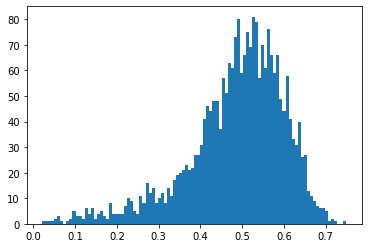

In [38]:
import matplotlib.pyplot as plt
plt.hist(submission.tm, bins=100)
plt.show()